# **Import Libraries and modules**

In [3]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

import cv2
import sys
from google.colab.patches import cv2_imshow

Using TensorFlow backend.


In [1]:
from google.colab import drive
drive.mount('../content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ../content/drive/


References:
1. https://colab.research.google.com/drive/10GugXUNI7ztK2joRZUnYyqRrQbYnOQE0
2. https://github.com/amitdoda1983/EVA-Session-10
3. https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47 (for 10B)
4. https://arxiv.org/pdf/1701.03056.pdf (for 10B)

# GRADCAM

In [0]:
import os
os.listdir('../content/drive/My Drive/EIP/')

['Assignment 1C.md',
 'keras-resnet-master',
 'resnet18_cifar10.csv',
 'weights-improvement-{epoch:02d}-{val_acc:.2f}}.hdf5',
 'wonderland.txt',
 'out.txt',
 'Final_Phase2',
 'model_assignment6A.h5',
 'model_assignment9.h5',
 'tony.jpg']

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
print("Shape of the train feaures :" +str(train_features.shape))
# (50000, 32, 32, 3)
num_train, img_rows, img_cols,img_channels =  train_features.shape
print("num_train : {}, img_rows : {}, img_cols : {}, img_channels : {} ".format(num_train, img_rows, img_cols,img_channels))
print("Shape of the test feaures :" +str(test_features.shape))
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))
print("No. of classes : "+str(num_classes))

Shape of the train feaures :(50000, 32, 32, 3)
num_train : 50000, img_rows : 32, img_cols : 32, img_channels : 3 
Shape of the test feaures :(10000, 32, 32, 3)
No. of classes : 10


Let's start with a pretrained VGG model

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2

1.  Loading helper functions
2.  Load VGG
3. Load Image
4. Rescale image to 224x224x3 (VGG's expectation, why?)
5. Use expand_dims to convert image to a batch of size 1
6. Preprocesing normalizes our input image by subtracting mean RGB values

In [0]:
model = VGG16(weights="imagenet") # Model
from skimage import io
testimage1 = test_features[10]
testimage1 = cv2.resize(testimage1, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(testimage1)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

###GradCAM at a layer, which is one before the final convolutional layer, which is block5_conv2

1. We get the predictions for the image
2. We take the topmost class index
3. Take output from the layer one before the final convolutional layer, which is block5_conv2

In [0]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv2")

812


In imagenet dataset, 812 is spaceshuttle 

1. Compute the gradient of the class output value with respect to the feature map
2. Pool the gradients over all the axies leaving out the channel dimension
3. Weigh the output feature map with the computed gradient values

In [0]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

(?, 14, 14, 512)
(512,)


1. Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14 
2. Normalize the heat map to make the values between 0 and 1

In [0]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(14, 14, 512)
(14, 14)


Show the results

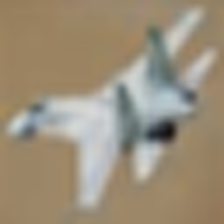

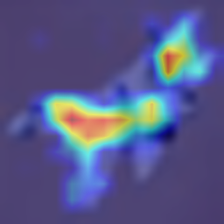

In [0]:
heatmap = cv2.resize(heatmap, (testimage1.shape[1], testimage1.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(testimage1, 0.5, heatmap, 0.5, 0)
from google.colab.patches import cv2_imshow
cv2_imshow( testimage1)
cv2_imshow(superimposed_img)

###GradCAM at a layer, which is two before the final convolutional layer, which is block5_conv1

In [0]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv1")

812


In [0]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

(?, 14, 14, 512)
(512,)


In [0]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(14, 14, 512)
(14, 14)


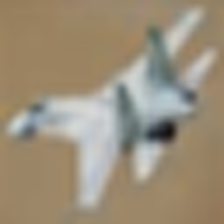

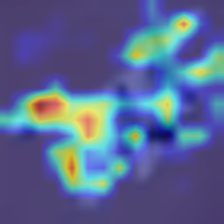

In [0]:
heatmap = cv2.resize(heatmap, (testimage1.shape[1], testimage1.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(testimage1, 0.5, heatmap, 0.5, 0)
from google.colab.patches import cv2_imshow
cv2_imshow( testimage1)
cv2_imshow(superimposed_img)

####GradCAM for sunglasses class on imagenet

In [0]:
model = VGG16(weights="imagenet")
from skimage import io
testimage2 = cv2.imread('../content/drive/My Drive/EIP/tony.jpg')
testimage2 = cv2.resize(testimage2, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(testimage2)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [0]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv3")

837


In [0]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

(?, 14, 14, 512)
(512,)


In [0]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(14, 14, 512)
(14, 14)


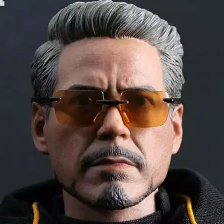

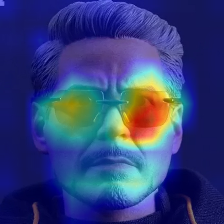

In [0]:
heatmap = cv2.resize(heatmap, (testimage2.shape[1], testimage2.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(testimage2, 0.5, heatmap, 0.5, 0)
from google.colab.patches import cv2_imshow
cv2_imshow( testimage2)
cv2_imshow(superimposed_img)

#10B. Receptive field

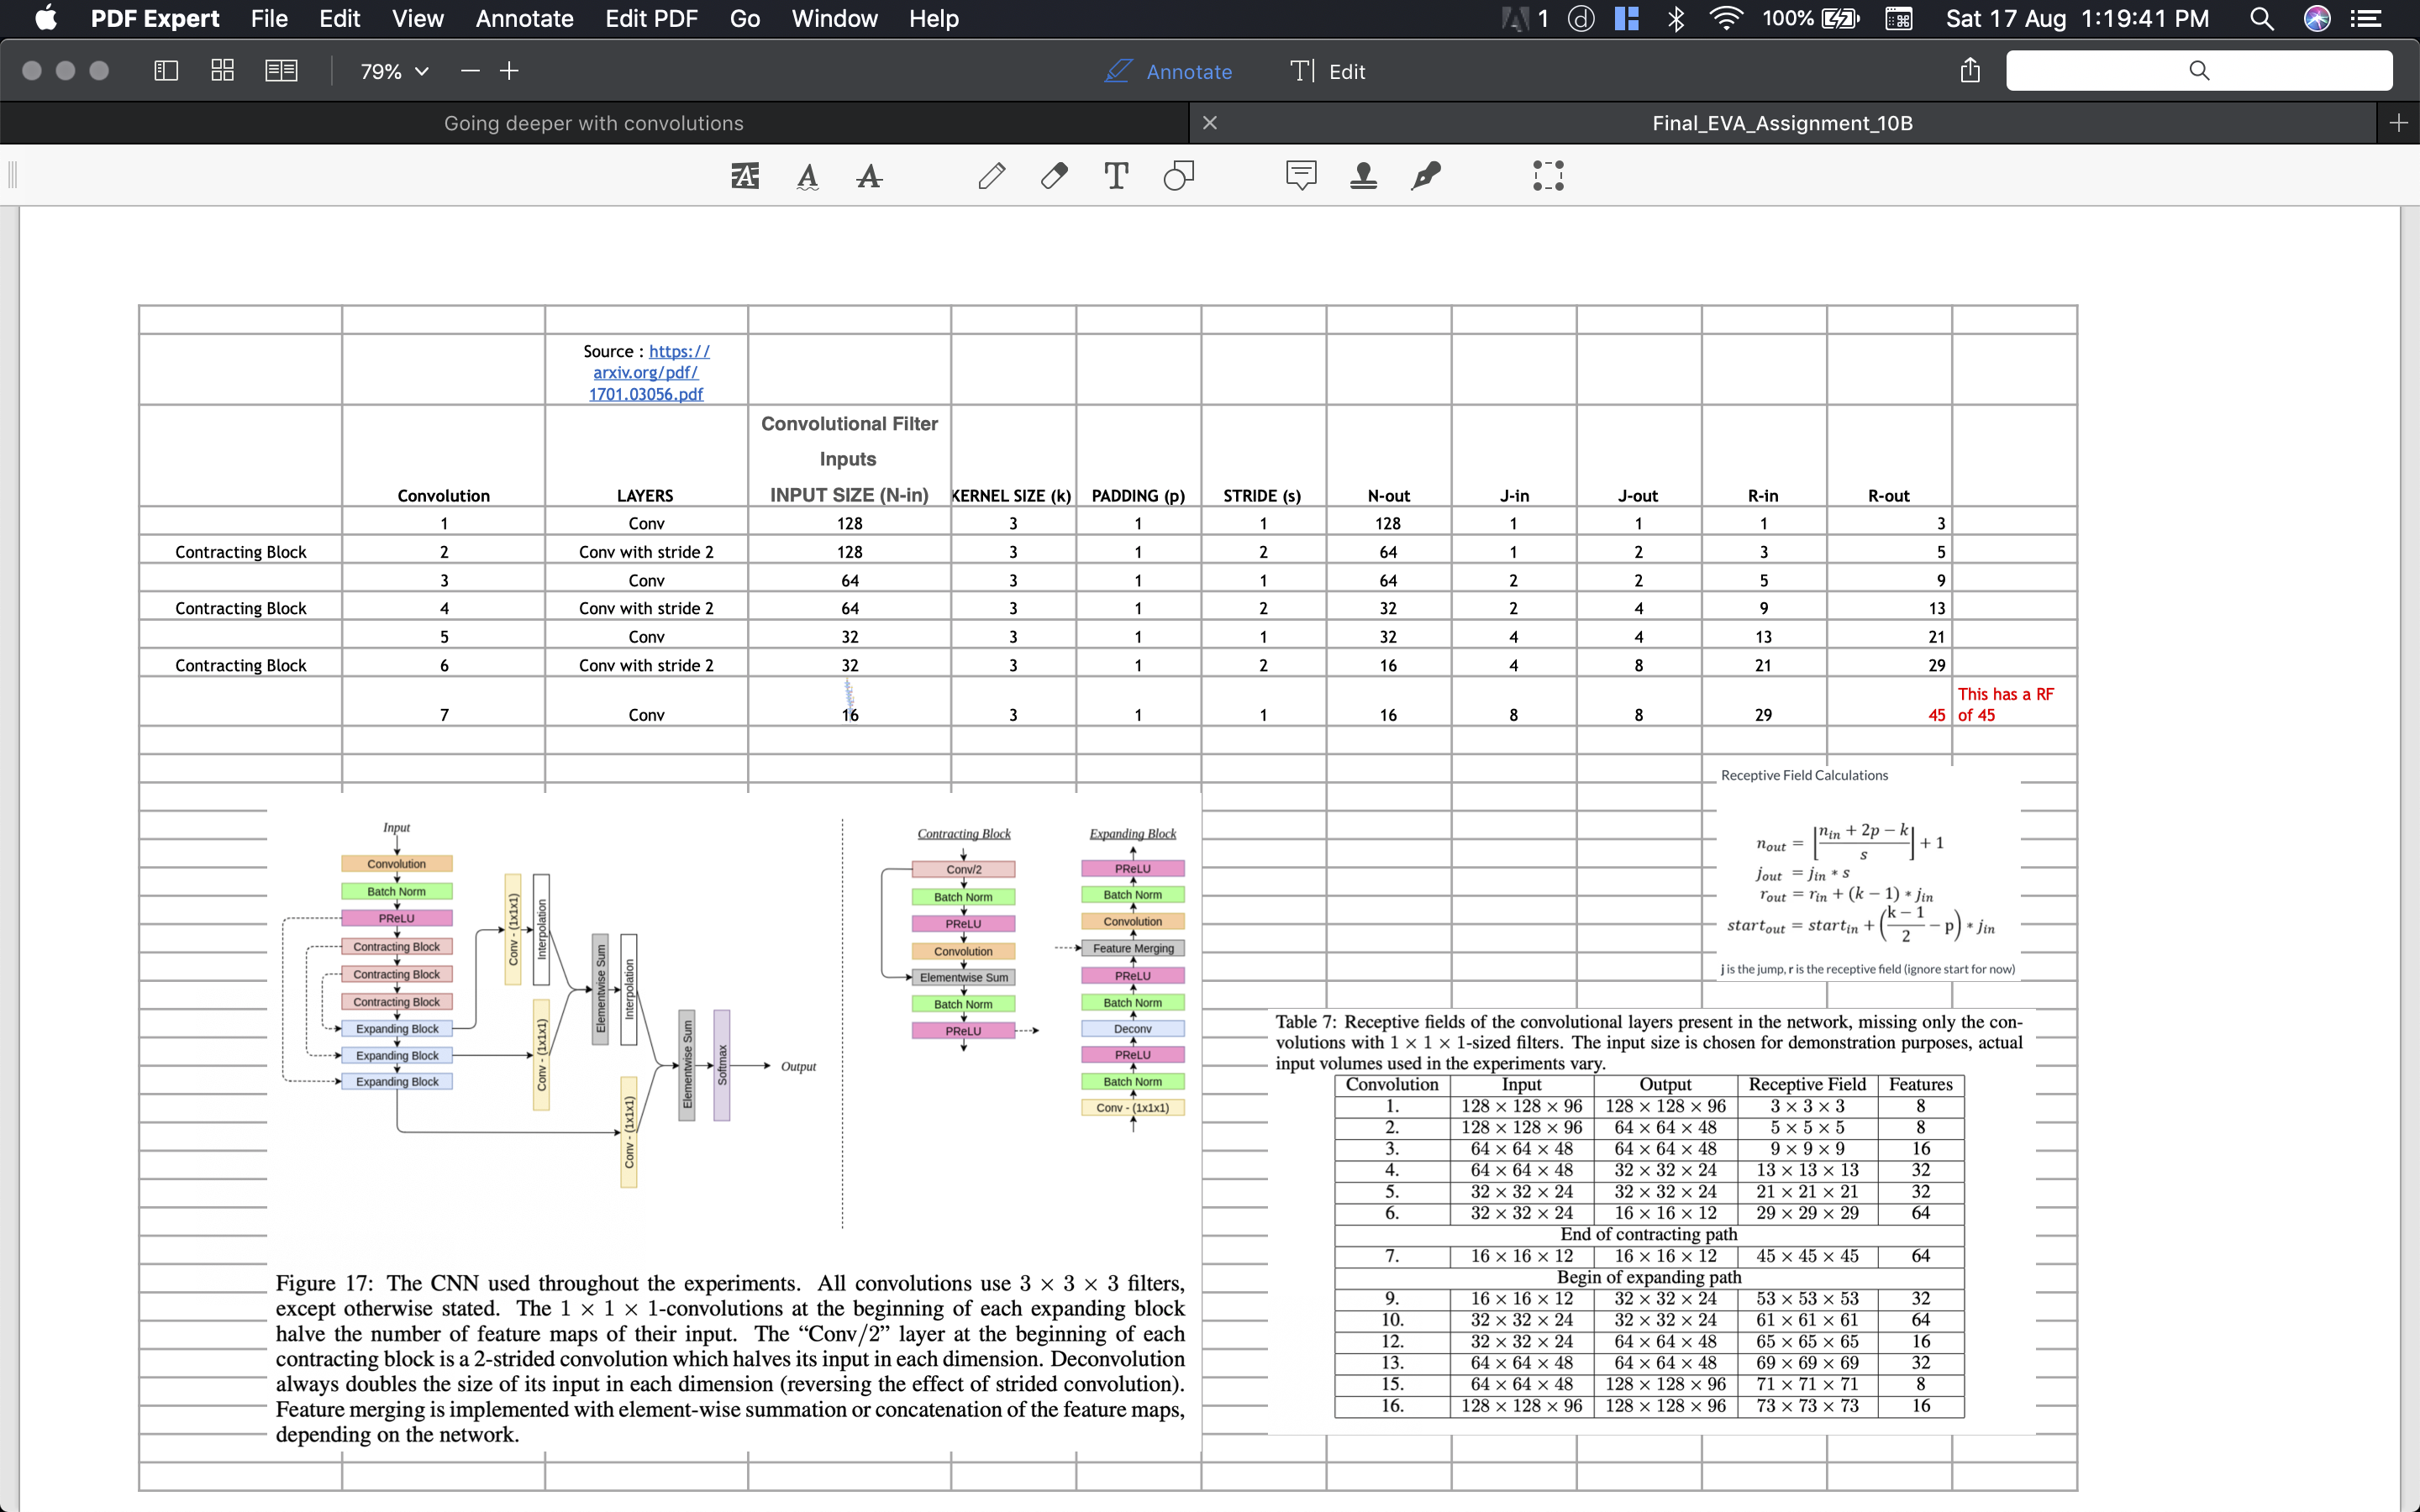

In [5]:
# Receptive Field calculation 
Receptive_field_29_to_45 = cv2.imread('../content/drive/My Drive/EIP/Final_EVA_Assignment_10B.png')
cv2_imshow(Receptive_field_29_to_45)